In [1]:
import pyomo.kernel as pmo
import pandas as pd

from plant_opt.models.plant_model_stages_recourse_stochastic_pyo import Plant


# Problem Overview

Recommendation:
- Review `compare_recourse_nb.ipynb` to understand the background, as the model in this case is a more complex version of the model in that notebook.
- Review `plant_opt/models/plant_model_stages_pyo.py` to understand the deterministic version of the model, as the stochastic version builds on this model.

The model is a (deliberately non-realistic) refinery model that takes in crude oil (light or heavy) and produces a configurable number of intermediate and output products.
The refinery has a distillation unit that can take in a certain amount of crude oil to produce intermediate products, and refining units that can take in intermediate products to produce the final products.
The ratios of inputs to intermediates, and intermediates to outputs are parameters passed to the constructor of the model: any desired "production matrix" can be specified.

The model applies over "stages" in time (e.g. months), and the prices and demands for the final products are different in each stage.
There is a constraint applied to the model that the amount of each output product produced in each stage cannot change by more than a certain amount from the previous stage.
- This somewhat artificial constraint creates a time dependence, which makes the problem more interesting in the stochastic case, where the future is uncertain.

The model is designed to optimize the production of the final products in each stage given the constraints of the distillation and refining units as well as:
- the ratios of crude oil to intermediate products
- the ratios of intermediate products to final products.
- the prices of the inputs (light/heavy crude oil) and outputs.
- The "demands" for the final products: above a certain amount, the product no longer has value.

## Modelling Notes
The stochastic model uses a "scenario tree" of node objects, that each contain values for the variables that can change over time; as well as links to child nodes that represent the possible future scenarios from that point.
This model uses the pyomo kernel interface instead of the older "environ" interface, in order to create a model structure more closely associated with the scenario tree.
Non-anticipativity constraints are implicit: decision variables are only created at notes where they can actually take different values (for non-recourse decisions, they exist at the root node and all non-terminal nodes beneath it, for recourse decisions, they exist at all the non-root nodes - reflecting how the decision is made after the information at that stage is known).
All scenarios are assumed to be equally likely.

## Comparison to be made

To investigate the value of the stochastic model, we will perform a comparison by:
 - Solve the model given the full scenario tree and see the objective value
 - replace the final stage nodes of the scenario tree with nodes that have the variable values set to the average value of the variable in that stage.
 - solve the model with these average values.
 - take the solved value of the import variables at the root node from the "average" model and apply it as a fixed value in the root node of the stochastic model.
 - solve the model again with these initial values applied, and see the objective value.
The above can be repeated by going "up a level" in the scenario tree, creating an even more reduced model, and seeing how the objective value changes.



# Data Generation
The `random_walk_tree_builder` function in `plant_opt/scenario_tree/tree.py` creates scenario trees by applying a random (drawn from a gaussian distribution, and limited by a cap value) change to the values of the variables at each stage.
For this case, we will generate a tree with 4 stages, branching twice at each node.
By setting the "walk_max" value to zero for the crude prices and product prices, we keep them the same throughout the tree; changing only the demands.



In [2]:
from plant_opt.scenario_tree.tree import random_walk_tree_builder

stages = 4

variables = [
            "crude_light_price",
            "crude_heavy_price",
            "prod_price_0",
            "prod_price_1",
            "prod_price_2",
            "demand_0",
            "demand_1",
            "demand_2",
        ]

root, all_nodes = random_walk_tree_builder(
        variables,
        [30, 20, 50, 40, 30, 400, 300, 200],
        [1, 1, 1, 1, 1, 30, 30, 30],
        [0, 0, 0, 0, 0, 60, 60, 60],
        stages=stages,
        branch_factor=2,
        seed=42,
        truncate_places=0,
    )

The following cell creates the averaged/truncated scenario trees:

In [3]:
from collections import defaultdict
from copy import deepcopy

# Last stage averaged tree
one_averaged_tree = deepcopy(all_nodes)
# last two stages averaged tree
two_averaged_tree = deepcopy(all_nodes)

nodes_by_stage = defaultdict(list)
for node in one_averaged_tree:
    nodes_by_stage[node.stage].append(node)

stages_list = list(range(stages))

last_stage = stages_list[-1]

avg_var_values = {}
for var in variables:
    avg_var_values[var] = sum([node.values[var] for node in nodes_by_stage[last_stage]]) / len(nodes_by_stage[last_stage])

for node in nodes_by_stage[last_stage]:
    for var in variables:
        node.values[var] = avg_var_values[var]


nodes_by_stage = defaultdict(list)
for node in two_averaged_tree:
    nodes_by_stage[node.stage].append(node)

# Same as above, we also need to average the last stage for "two_averaged_tree"
for node in nodes_by_stage[last_stage]:
    for var in variables:
        node.values[var] = avg_var_values[var]

second_last_stage = stages_list[-2]
avg_var_values = {}
for var in variables:
    avg_var_values[var] = sum([node.values[var] for node in nodes_by_stage[second_last_stage]]) / len(nodes_by_stage[second_last_stage])

for node in nodes_by_stage[second_last_stage]:
    for var in variables:
        node.values[var] = avg_var_values[var]

print("Initial tree:")
for node in all_nodes:
    print(node.detail_str())

print("One stage averaged tree:")
for node in one_averaged_tree:
    print(node.detail_str())

print("Two stage averaged tree:")
for node in two_averaged_tree:
    print(node.detail_str())


Initial tree:
Node(root, None, 0, {'crude_light_price': 30, 'crude_heavy_price': 20, 'prod_price_0': 50, 'prod_price_1': 40, 'prod_price_2': 30, 'demand_0': 400, 'demand_1': 300, 'demand_2': 200})
Node(root_0, root, 1, {'crude_light_price': np.float64(30.0), 'crude_heavy_price': np.float64(20.0), 'prod_price_0': np.float64(50.0), 'prod_price_1': np.float64(40.0), 'prod_price_2': np.float64(30.0), 'demand_0': np.float64(361.0), 'demand_1': np.float64(304.0), 'demand_2': np.float64(191.0)})
Node(root_1, root, 1, {'crude_light_price': np.float64(30.0), 'crude_heavy_price': np.float64(20.0), 'prod_price_0': np.float64(50.0), 'prod_price_1': np.float64(40.0), 'prod_price_2': np.float64(30.0), 'demand_0': np.float64(434.0), 'demand_1': np.float64(314.0), 'demand_2': np.float64(174.0)})
Node(root_0_0, root_0, 2, {'crude_light_price': np.float64(30.0), 'crude_heavy_price': np.float64(20.0), 'prod_price_0': np.float64(50.0), 'prod_price_1': np.float64(40.0), 'prod_price_2': np.float64(30.0), 'd

## Model Solving

In [4]:
opt = pmo.SolverFactory("glpk")

In [5]:
# Some constants for all models
crude_distil_cap = 1000
products = 3
crude_ratios = [[3, 1], [1, 2], [0, 1]]
refine_caps = [1000, 1000, 1000]
product_ratios = [
            [2, 1, 0.0],  # Amount of light product from l/m/h intermediates
            [0.2, 1.0, 0.2],  # Amount of medium product from l/m/h intermediates
            [0.0, 0.8, 2.0],  # Amount of heavy product from l/m/h intermediates
        ]
allowed_output_change = 20

In [6]:
p_full = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=product_ratios,
        stages=stages,
        scenario_tree_root=root,
        scenario_tree_all_nodes=all_nodes,
        allowed_output_change=allowed_output_change,
    )

p_one_averaged = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=product_ratios,
        stages=stages,
        scenario_tree_root=one_averaged_tree[0],
        scenario_tree_all_nodes=one_averaged_tree,
        allowed_output_change=allowed_output_change,
    )

p_two_averaged = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=product_ratios,
        stages=stages,
        scenario_tree_root=two_averaged_tree[0],
        scenario_tree_all_nodes=two_averaged_tree,
        allowed_output_change=allowed_output_change,
    )

In [7]:
# Basic solving of the models
result_df = pd.DataFrame(columns=["Model", "Objective Value", "Light Crude Import", "Heavy Crude Import"])

opt.solve(p_full.model)
result_df.loc[0] = ("Full Model", pmo.value(p_full.model.obj), pmo.value(p_full.model.light_crude_import[root]), pmo.value(p_full.model.heavy_crude_import[root]))

opt.solve(p_one_averaged.model)
one_avg_root = one_averaged_tree[0]
result_df.loc[1] = ("One Stage Averaged", pmo.value(p_one_averaged.model.obj), pmo.value(p_one_averaged.model.light_crude_import[one_avg_root]), pmo.value(p_one_averaged.model.heavy_crude_import[one_avg_root]))

opt.solve(p_two_averaged.model)
two_avg_root = two_averaged_tree[0]
result_df.loc[2] = ("Two Stage Averaged", pmo.value(p_two_averaged.model.obj), pmo.value(p_two_averaged.model.light_crude_import[two_avg_root]), pmo.value(p_two_averaged.model.heavy_crude_import[two_avg_root]))

Now apply the values from the averaged models to the full model (fixing the initial value) and solve again to determine the objective value:

In [8]:
p_full.model.light_crude_import[root].fixed = True
p_full.model.heavy_crude_import[root].fixed = True

p_full.model.light_crude_import[root].value = pmo.value(p_one_averaged.model.light_crude_import[one_avg_root])
p_full.model.heavy_crude_import[root].value = pmo.value(p_one_averaged.model.heavy_crude_import[one_avg_root])

opt.solve(p_full.model)
result_df.loc[3] = ("Full Model with One Stage Averaged", pmo.value(p_full.model.obj), pmo.value(p_full.model.light_crude_import[root]), pmo.value(p_full.model.heavy_crude_import[root]))

p_full.model.light_crude_import[root].value = pmo.value(p_two_averaged.model.light_crude_import[two_avg_root])
p_full.model.heavy_crude_import[root].value = pmo.value(p_two_averaged.model.heavy_crude_import[two_avg_root])

opt.solve(p_full.model)
result_df.loc[4] = ("Full Model with Two Stage Averaged", pmo.value(p_full.model.obj), pmo.value(p_full.model.light_crude_import[root]), pmo.value(p_full.model.heavy_crude_import[root]))

## Results

In [9]:
from IPython.display import display
display(result_df)

,Model,Objective Value,Light Crude Import,Heavy Crude Import
0,Full Model,102920.729167,17.333333,154.777778
1,One Stage Averaged,103054.801587,17.333333,154.777778
2,Two Stage Averaged,103285.970982,26.071429,138.785714
3,Full Model with One Stage Averaged,102920.729167,17.333333,154.777778
4,Full Model with Two Stage Averaged,102662.891865,26.071429,138.785714


Observations/Explanations:
- The objective value of the "averaged" models is higher, as the model is no longer attempting to account for uncertainty in the relevant stages
    - The model "thinks" that it can achieve higher value, which makes sense as there is no longer variation to account for
- The objective value of the full model with the "two stage averaged" values is lower, which makes sense, as the model is "locked in" to a suboptimal decision (w.r.t the variance in outcomes).
- Most interestingly, the objective value of the full model with the "one stage averaged" values is the exact same as the original full model:
    - This is expected once we observe that the light/heavy crude import values are the same in the "one stage averaged" model as in the original full model.
    - The implication here is that outcomes of the future stages are not having a large enough effect to matter at the first stage of the model.
        - In the real world, time/money could be saved by not considering the farther future stages in the model, as the model would be re-solved at each point in time anyways as outcomes were realized.
    - Future exploration could explore variations in the scenario tree to create situations where this is not the case - determine what circumstances are required for the future stages to matter at the first stage.

## Distributions
We will cover a create a larger range of scenarios and then plot the distribution of outcomes by building an accessory function to calculate the objective value of a given node, and applying it, starting from the terminal nodes and tracing upwards to the root.

In [10]:
# Create a larger scenario tree and solve
stages = 6
root, all_nodes = random_walk_tree_builder(
        variables,
        [30, 20, 50, 40, 30, 400, 300, 200],
        [1, 1, 1, 1, 1, 30, 30, 30],
        [0, 0, 0, 0, 0, 60, 60, 60],
        stages=stages,
        branch_factor=5,
        seed=42,
        truncate_places=0,
    )
print(f"Generated {len(all_nodes)} nodes")

p_many = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=product_ratios,
        stages=stages,
        scenario_tree_root=root,
        scenario_tree_all_nodes=all_nodes,
        allowed_output_change=allowed_output_change,
    )
opt.solve(p_many.model)

Generated 3906 nodes


{'Problem': [{'Name': 'unknown', 'Lower bound': 169241.56015412, 'Upper bound': 169241.56015412, 'Number of objectives': 1, 'Number of constraints': 85099, 'Number of variables': 74195, 'Number of nonzeros': 222525, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 37.80270075798035}], 'Solution': [OrderedDict({'number of solutions': 1, 'number of solutions displayed': 1}), {'Gap': 0.0, 'Status': 'feasible', 'Problem': {}, 'Objective': {'x1': {'Value': 169241.56015412}}, 'Variable': {'x2': {'Value': 361.0}, 'x3': {'Value': 304.0}, 'x4': {'Value': 191.0}, 'x5': {'Value': 15.6071428571429}, 'x6': {'Value': 167.678571428571}, 'x7': {'Value': 434.0}, 'x8': {'Value': 314.0}, 'x9': {'Value': 174.0}, 'x10': {'Value': 380.0}, 'x11': {'Value': 337.0}, 'x12': {'Value': 195.0}, 'x13': {'Value': 413.0}, 'x14': {'Value': 360.0}, 'x

In [11]:
def calculate_node_objective(m, node):
    node_val = 0
    for output in m.outputs:
        node_val += pmo.value(m.prod_full_price[node][output]) * node.values[f"prod_price_{output}"]
    node_val -= pmo.value(m.light_crude_import[node.parent]) * node.values["crude_light_price"]
    node_val -= pmo.value(m.heavy_crude_import[node.parent]) * node.values["crude_heavy_price"]

    return node_val

def calculate_node_objective_recursive(m, node):
    if node.parent is None:
        # Don't calculate objective value at the root node, as the values at its children will use the import costs from it already
        return 0

    node_val = calculate_node_objective(m, node)

    return node_val + calculate_node_objective_recursive(m, node.parent)

In [16]:
terminal_nodes = [node for node in all_nodes if node.stage == stages - 1]

distributions = pd.DataFrame(columns=["Node", "Objective Value"])

# The actual value of the objective does not matter much, so scale it for easier plotting
scale_factor = 1/10000

for i, node in enumerate(terminal_nodes):
    distributions.loc[i] = (node.name, calculate_node_objective_recursive(p_many.model, node)*scale_factor)

In [17]:
display(distributions)

,Node,Objective Value
0,root_0_0_0_0_0,16.022804
1,root_0_0_0_0_1,16.008804
2,root_0_0_0_0_2,15.954804
3,root_0_0_0_0_3,15.815804
4,root_0_0_0_0_4,16.162804
...,...,...
3120,root_4_4_4_4_0,15.893927
3121,root_4_4_4_4_1,16.013927
3122,root_4_4_4_4_2,15.828927
3123,root_4_4_4_4_3,15.690927


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
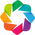

:Histogram   [x]   (Frequency)

In [18]:
# Plot histogram
import numpy as np
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

frequencies, edges = np.histogram(distributions["Objective Value"], 20)
hv.Histogram((edges, frequencies))

From this point, recommend continuing in the `stochastic_modified_nb.ipynb` notebook, which uses a model implemented in CVXPY to create more advanced constraints and examine their effects